In [1]:
import numpy as np
import polars as pl
import pandas as pd
import os
import random

In [2]:
# Download the optimized data file into a folder. Use this code to create a folder of files. 
# The files are grouped by video, as each video has a number of frames associated with it. 

parquet_file = "emotion_landmark_dataset.parquet"
output_dir = "video_frames_npz"
os.makedirs(output_dir, exist_ok=True)

x_cols = [f"x_{i}" for i in range(478)]
y_cols = [f"y_{i}" for i in range(478)]
z_cols = [f"z_{i}" for i in range(478)]

chunk_size = 10000  # adjust to your memory

# Dictionary to accumulate frames per video
video_data = {}

lf = pl.scan_parquet(parquet_file)
total_rows = lf.select(pl.len()).collect()[0, 0]

def append_to_npz(filename, coords, emotions, frame_nums):
    if os.path.exists(filename):
        # Load old arrays and concatenate
        data = np.load(filename, allow_pickle=True)  # <-- allow_pickle=True
        old_coords = data['coords']
        old_emotions = data['emotions']
        old_frames = data['frame_nums']

        coords = np.concatenate([old_coords, coords], axis=0)
        emotions = np.concatenate([old_emotions, emotions], axis=0)
        frame_nums = np.concatenate([old_frames, frame_nums], axis=0)

    # Save updated arrays
    np.savez_compressed(filename, coords=coords, emotions=emotions, frame_nums=frame_nums)

for start in range(0, total_rows, chunk_size):
    df_chunk = lf.slice(start, chunk_size).collect().to_pandas()
    print(f"Processing rows {start}-{start + len(df_chunk)}")

    for video_name, group in df_chunk.groupby("video_filename", observed=False):
        x = group[x_cols].to_numpy(dtype='float32')
        y = group[y_cols].to_numpy(dtype='float32')
        z = group[z_cols].to_numpy(dtype='float32')
        coords = np.stack([x, y, z], axis=-1)
        emotions = group["emotion"].to_numpy()
        frame_nums = group["frame_num"].to_numpy()

        filename = os.path.join(output_dir, f"{video_name}.npz")
        append_to_npz(filename, coords, emotions, frame_nums)

print("All videos saved incrementally!")

Processing rows 0-10000
Processing rows 10000-20000
Processing rows 20000-30000
Processing rows 30000-40000
Processing rows 40000-50000
Processing rows 50000-60000
Processing rows 60000-70000
Processing rows 70000-80000
Processing rows 80000-90000
Processing rows 90000-100000
Processing rows 100000-110000
Processing rows 110000-120000
Processing rows 120000-130000
Processing rows 130000-140000
Processing rows 140000-150000
Processing rows 150000-160000
Processing rows 160000-170000
Processing rows 170000-180000
Processing rows 180000-190000
Processing rows 190000-200000
Processing rows 200000-210000
Processing rows 210000-220000
Processing rows 220000-230000
Processing rows 230000-240000
Processing rows 240000-250000
Processing rows 250000-260000
Processing rows 260000-270000
Processing rows 270000-280000
Processing rows 280000-290000
Processing rows 290000-300000
Processing rows 300000-310000
Processing rows 310000-320000
Processing rows 320000-330000
Processing rows 330000-340000
Pro

In [3]:
# Testing code. Good to use for implementation. 

folder = "video_frames_npz"

# Randomly pick a file
file_path = os.path.join(folder, random.choice(os.listdir(folder)))
print("Inspecting file:", file_path)

# Load the file
data = np.load(file_path, allow_pickle=True)

# Stored in a (num_frames, 478, 3) tensor. 
data_coords = data['coords']
num_frames = data_coords[:,0,0].size

# For a specific frame, grab the x, y and z coordinate data. 
frame_num = 0
x_coords = data_coords[frame_num, :, 0]
y_coords = data_coords[frame_num, :, 1]
z_coords = data_coords[frame_num, :, 2]

# For the specific frame, grab the emotion. 
frame_emotion = data['emotions'][frame_num]

Inspecting file: video_frames_npz\1009_TSI_FEA_XX.flv.npz


Found NPZ files: 7441
Train files: 5952, Test files: 1489
Train matrix: (454862, 1434)
Test matrix: (114244, 1434)
Running PCA (50 components)...
Shape after PCA: (454862, 50)

Testing different k values...


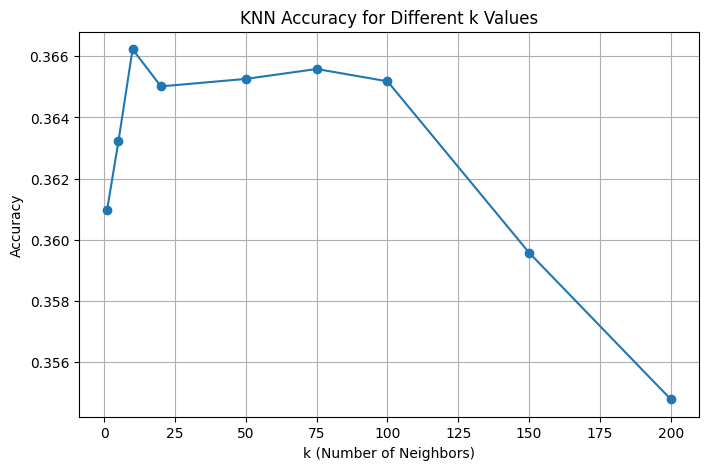


Best k = 10 with accuracy = 0.3662

--- FINAL KNN RESULTS ---
Accuracy: 0.3662
Confusion Matrix:
 [[6336 2676 3058 1941 2212 3080]
 [2645 9220 3227 1964 2070 3225]
 [3363 3527 6178 1321 2897 3933]
 [1872 1385 1311 8079 2269 1331]
 [1497 1445 1781 2390 5707 2692]
 [3130 2566 3301 1233 3062 6320]]

Average prediction entropy: 0.2169


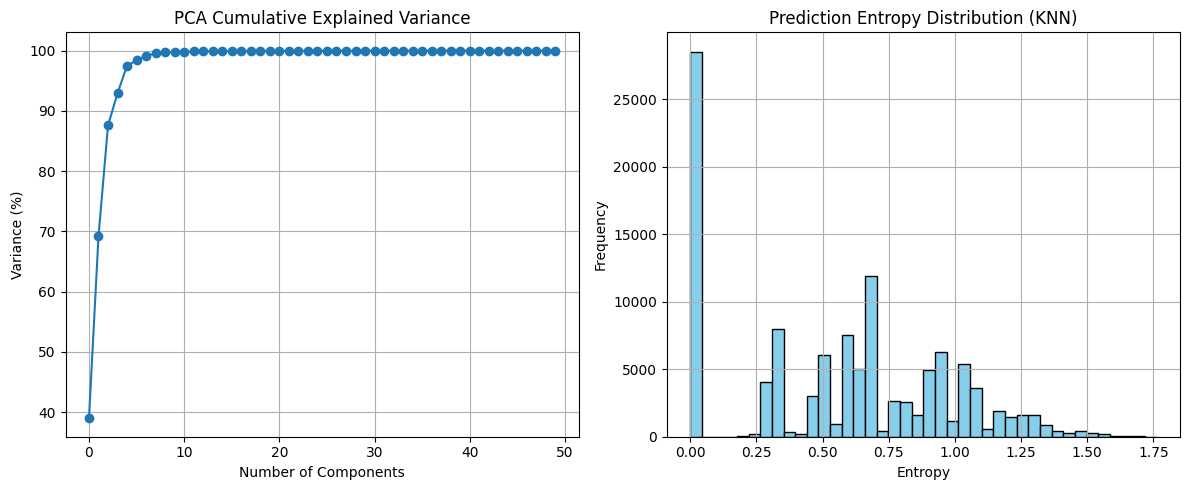

In [4]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import entropy
import matplotlib.pyplot as plt

# load npz files and split by files
folder = "video_frames_npz"
npz_files = [f for f in os.listdir(folder) if f.endswith(".npz")]

print("Found NPZ files:", len(npz_files))

# shuffle the list of files so we don't bias the split
# (splitting by file avoids identity leakage, since frames from the same video
# shouldn't appear in both train and test)
np.random.shuffle(npz_files)

split_idx = int(len(npz_files) * 0.8)
train_files = npz_files[:split_idx]
test_files  = npz_files[split_idx:]

print(f"Train files: {len(train_files)}, Test files: {len(test_files)}")

# load train data (80% of the files)
X_train_list, y_train_list = [], []

for file in train_files:
    # each file contains multiple frames of one video
    data = np.load(os.path.join(folder, file), allow_pickle=True)
    coords = data["coords"].reshape(data["coords"].shape[0], -1)
    emotions = data["emotions"]

    X_train_list.append(coords)
    y_train_list.append(emotions)

X_train_raw = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)

print("Train matrix:", X_train_raw.shape)

# load test data (remaining 20% of files)
X_test_list, y_test_list = [], []

for file in test_files:
    data = np.load(os.path.join(folder, file), allow_pickle=True)
    coords = data["coords"].reshape(data["coords"].shape[0], -1)
    emotions = data["emotions"]

    X_test_list.append(coords)
    y_test_list.append(emotions)

X_test_raw = np.vstack(X_test_list)
y_test = np.concatenate(y_test_list)

print("Test matrix:", X_test_raw.shape)

# label encoding and feature scaling
# convert string labels ("happy", "anger", etc.) into 0–K integer classes
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# standardize coordinates so PCA + KNN work properly
# (PCA is very sensitive to scaling; leaving raw coordinates hurts performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# PCA for dimensionality reduction
print("Running PCA (50 components)...")
pca = PCA(n_components=50, random_state=42)

pca.fit(X_train_scaled)

X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

print("Shape after PCA:", X_train.shape)

# testing multiple k-values to see which one is the best
k_values = [1, 5, 10, 20, 50, 75, 100, 150, 200]
acc_list = []
entropy_list = []

print("\nTesting different k values...")
for k in k_values:
    knn_k = KNeighborsClassifier(
        n_neighbors=k,
        metric="euclidean",
        weights="distance"
    )

    # train the model
    knn_k.fit(X_train, y_train_enc)

    # evaluate
    y_pred_k = knn_k.predict(X_test)
    y_prob_k = knn_k.predict_proba(X_test)

    # standarn classification accuracy 
    acc_k = accuracy_score(y_test_enc, y_pred_k)
    acc_list.append(acc_k)


    H_k = entropy(y_prob_k.T)
    normalized_H_k = H_k / np.log2(6)  # scale to [0, 1]; 6 classes
    entropy_list.append(np.mean(normalized_H_k))

# plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, acc_list, marker='o')
plt.title("KNN Accuracy for Different k Values")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# use the best k value (highest accuracy)
best_k = k_values[np.argmax(acc_list)]
print(f"\nBest k = {best_k} with accuracy = {max(acc_list):.4f}")

# train the final model using the best k
knn = KNeighborsClassifier(
    n_neighbors=best_k,
    metric="euclidean",
    weights="distance"
)
knn.fit(X_train, y_train_enc)

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

# accuracy and confusion matrix
acc = accuracy_score(y_test_enc, y_pred)
cm = confusion_matrix(y_test_enc, y_pred)

print("\n--- FINAL KNN RESULTS ---")
print("Accuracy:", round(acc, 4))
print("Confusion Matrix:\n", cm)

entropies = entropy(y_prob.T)
normalized_entropy = entropies / np.log2(6)
avg_entropy = np.mean(normalized_entropy)
print("\nAverage prediction entropy:", round(avg_entropy, 4))

# plots for PCA variance and entropy visualization
plt.figure(figsize=(12,5))

# cumulative variance plot
plt.subplot(1,2,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100, marker='o')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")
plt.grid(True)

# how confident the model tends to be
plt.subplot(1,2,2)
plt.hist(entropies, bins=40, color='skyblue', edgecolor='black')
plt.title("Prediction Entropy Distribution (KNN)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

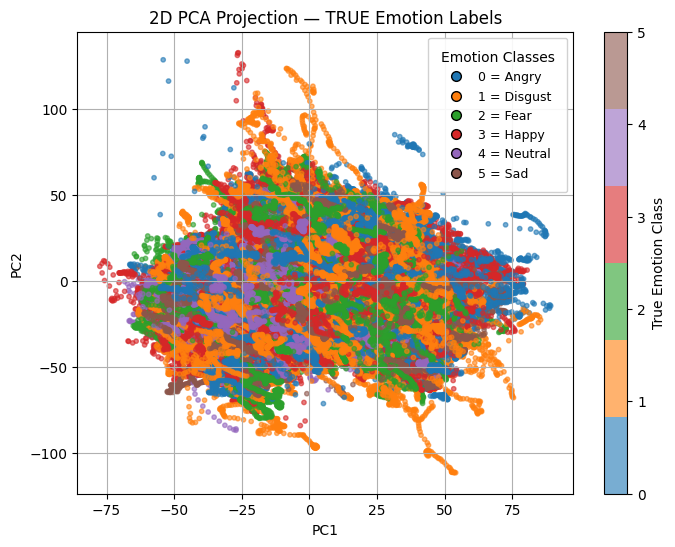

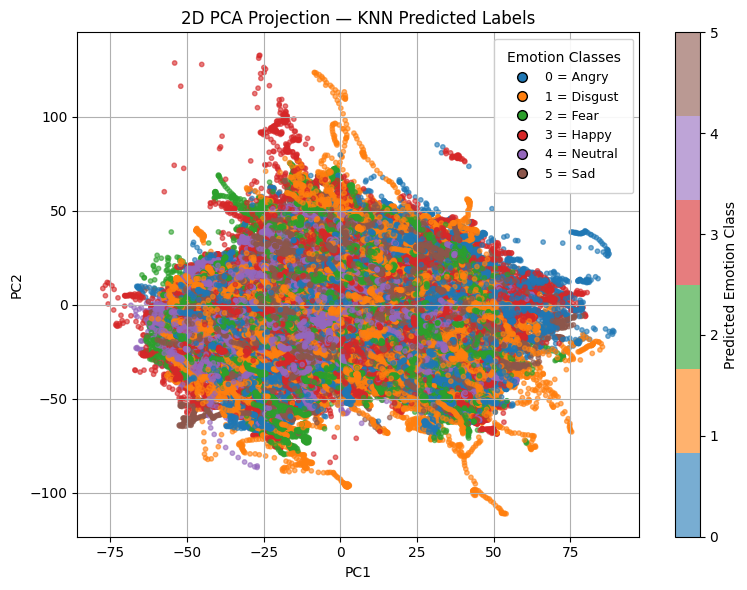

In [5]:
# 2D PCA visualization
from matplotlib.colors import ListedColormap

# build a separate PCA for visualization (2D)
pca2 = PCA(n_components=2, random_state=42)

# combine train and test so visualization reflects full dataset
X_all_2d = pca2.fit_transform(np.vstack([X_train_scaled, X_test_scaled]))

# predict KNN labels for the entire dataset
knn_all_preds = knn.predict(pca.transform(np.vstack([X_train_scaled, X_test_scaled])))

# extract emotion class names
classes = le.classes_

cmap = ListedColormap(plt.colormaps["tab10"].colors[:len(classes)])

# plot true labels 
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_all_2d[:,0], X_all_2d[:,1],
    c=np.concatenate([y_train_enc, y_test_enc]),
    cmap=cmap, s=10, alpha=0.6, vmin=0,
    vmax=len(classes)-1 
)
plt.title("2D PCA Projection — TRUE Emotion Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="True Emotion Class")
plt.grid(True)

# Legend with correct mapped colors
handles = []
for idx, emotion in enumerate(classes):
    handles.append(
        plt.Line2D(
            [], [], marker="o", linestyle="",
            markerfacecolor=cmap(idx), markeredgecolor="black",
            label=f"{idx} = {emotion}", markersize=7
        )
    )

plt.legend(
    handles=handles,
    title="Emotion Classes",
    loc="upper right",
    fontsize=9,
    title_fontsize=10,
    framealpha=0.9,
    borderpad=1
)

# plot our model's predictions
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_all_2d[:,0], X_all_2d[:,1],
    c=knn_all_preds,
    cmap=cmap, s=10, alpha=0.6, 
    vmin=0,
    vmax=len(classes)-1 
)
plt.title("2D PCA Projection — KNN Predicted Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Predicted Emotion Class")
plt.grid(True)

handles = []
for idx, emotion in enumerate(classes):
    handles.append(
        plt.Line2D(
            [], [], marker="o", linestyle="",
            markerfacecolor=cmap(idx), markeredgecolor="black",
            label=f"{idx} = {emotion}", markersize=7
        )
    )

plt.legend(
    handles=handles,
    title="Emotion Classes",
    loc="upper right",
    fontsize=9,
    title_fontsize=10,
    framealpha=0.9,
    borderpad=1
)

plt.tight_layout()
plt.show()